<a href="https://colab.research.google.com/github/avneetahuja/research-papers-implementation/blob/main/vae_implementation_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

-Encoder decoder architecture(nn for both)
-USed MNIST and Frey Face datasets for training
-sga for updating
-hidden units of encoder = decoder
- sample from a standard gaussian

Lets start with just the encoder and move from there

In [11]:
class VAE_Encoder(nn.Module):
  def __init__(self, in_features, h1, h2, h3, latent_size):
      super(VAE_Encoder, self).__init__()
      self.fc1 = nn.Linear(in_features, h1)
      self.fc2 = nn.Linear(h1, h2)
      self.fc3 = nn.Linear(h2, h3)
      self.fc_mu = nn.Linear(h3, latent_size)  # Layer for mean
      self.fc_logvar = nn.Linear(h3, latent_size)  # Layer for log-variance

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      mu = self.fc_mu(x)  # Mean of the latent space
      logvar = self.fc_logvar(x)  # Log-variance of the latent space
      return mu, logvar


In [24]:
#Lets load the MNIST dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    # transforms.Normalize(0.1307, 0.3081)  # Normalize to mean=0.1307, std=0.3081
])
mnist_train = datasets.MNIST(root='./datasets', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

In [25]:
model = VAE_Encoder(784, 512, 256, 128, 32)
results=[]

In [26]:
for images, labels in train_loader:
  # print(images.mean().item(), images.std().item())
  images = images.reshape(images.size(0),-1)
  results.append(model(images))

In [27]:
print(results[-2][0].shape)

torch.Size([64, 32])


now that we have the encoder, lets work on the reparameterization trick mentioned in the paper for sampling z

In [28]:
class VAE_Encoder_With_ReParameterization(nn.Module):
  def __init__(self, in_features, h1, h2, h3, latent_size):
      super(VAE_Encoder_With_ReParameterization, self).__init__()
      self.fc1 = nn.Linear(in_features, h1)
      self.fc2 = nn.Linear(h1, h2)
      self.fc3 = nn.Linear(h2, h3)
      self.fc_mu = nn.Linear(h3, latent_size)  # Layer for mean
      self.fc_logvar = nn.Linear(h3, latent_size)  # Layer for log-variance

  def reparameterizer(self,mu,logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      mu = self.fc_mu(x)  # Mean of the latent space
      logvar = self.fc_logvar(x)  # Log-variance of the latent space
      z = self.reparameterizer(mu,logvar)
      return z, mu, logvar

In [29]:
encoder = VAE_Encoder_With_ReParameterization(784, 392, 196, 128, 20)
dummy_input = torch.randn(64, 784)  # Batch size = 64, input features = 784
z, mu, logvar = encoder(dummy_input)
print("z shape:", z.shape)
print("mu shape:", mu.shape)
print("logvar shape:", logvar.shape)


z shape: torch.Size([64, 20])
mu shape: torch.Size([64, 20])
logvar shape: torch.Size([64, 20])


OK Now we can work towards the decoder and finally define the custom loss function


In [30]:
class VAE_Encoder_Decoder_ReParam(nn.Module):

  def __init__(self, in_features, h1, h2, h3, latent_size):
    super(VAE_Encoder_Decoder_ReParam, self).__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc_mu = nn.Linear(h3, latent_size)  # Layer for mean
    self.fc_logvar = nn.Linear(h3, latent_size)  # Layer for log-variance
    self.fc4 = nn.Linear(latent_size, h3)
    self.fc5 = nn.Linear(h3, h2)
    self.fc6 = nn.Linear(h2, h1)
    self.out = nn.Linear(h1, in_features)

  def reparameterizer(self,mu,logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterizer(mu,logvar)
    x = F.relu(self.fc4(z))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = torch.sigmoid(self.out(x))
    return x, mu, logvar

In [31]:
model = VAE_Encoder_Decoder_ReParam(784, 392, 196, 128, 20)
dummy_input = torch.randn(64, 784)
reconstructed, mu, logvar = model(dummy_input)
print("Reconstructed shape:", reconstructed.shape)
print("mu shape:", mu.shape)
print("logvar shape:", logvar.shape)

Reconstructed shape: torch.Size([64, 784])
mu shape: torch.Size([64, 20])
logvar shape: torch.Size([64, 20])


OK seems ike its working as expected, now we need to make a loss function that does BCE + KLD

In [20]:
class VAE_Encoder_Decoder_ReParam_With_Loss(nn.Module):

  def __init__(self, in_features, h1, h2, h3, latent_size):
    super(VAE_Encoder_Decoder_ReParam_With_Loss, self).__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc_mu = nn.Linear(h3, latent_size)  # Layer for mean
    self.fc_logvar = nn.Linear(h3, latent_size)  # Layer for log-variance
    self.fc4 = nn.Linear(latent_size, h3)
    self.fc5 = nn.Linear(h3, h2)
    self.fc6 = nn.Linear(h2, h1)
    self.out = nn.Linear(h1, in_features)

  def reparameterizer(self,mu,logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def loss_function(self,x, reconstructed, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed,x,reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))

    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterizer(mu,logvar)

    x = F.relu(self.fc4(z))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = torch.sigmoid(self.out(x))
    return x, mu, logvar

In [33]:
# Import required module for the optimizer
import torch.optim as optim

# Initialize the model, optimizer, and number of epochs
model = VAE_Encoder_Decoder_ReParam_With_Loss(784, 392, 196, 128, 20)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for image, label in train_loader:
        # Flatten the images
        image = image.view(image.size(0), -1)

        # Forward pass
        reconstructed, mu, logvar = model(image)

        # Compute the loss
        loss = model.loss_function(image, reconstructed, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        train_loss += loss.item()

    # Average loss per epoch
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 178.1611
Epoch [2/10], Loss: 136.7360
Epoch [3/10], Loss: 128.2132
Epoch [4/10], Loss: 124.8584
Epoch [5/10], Loss: 122.5569
Epoch [6/10], Loss: 120.8085
Epoch [7/10], Loss: 119.5795
Epoch [8/10], Loss: 117.9781
Epoch [9/10], Loss: 116.0543
Epoch [10/10], Loss: 114.4731


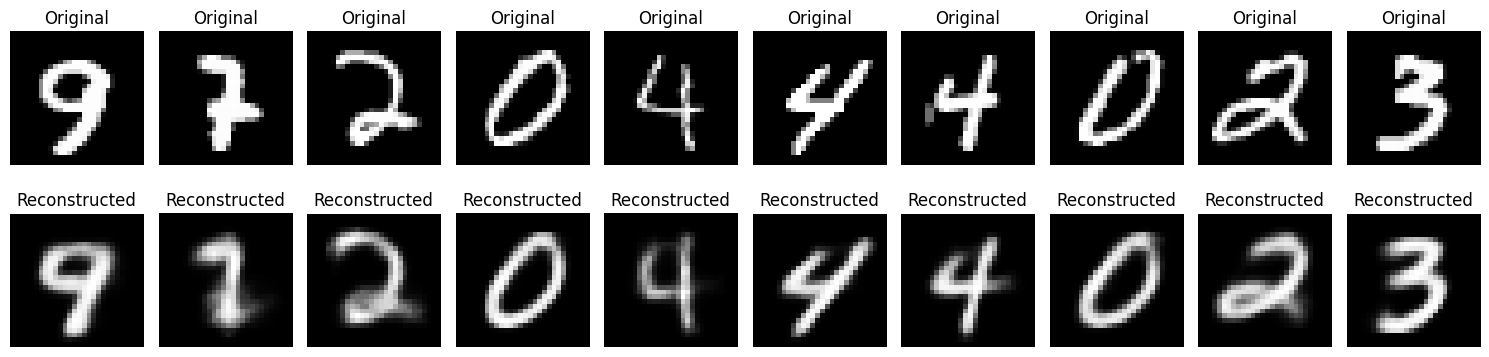

In [38]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Fetch a single batch of test data
images, labels = next(iter(test_loader))

# Flatten the images to match the model's input shape
images_flat = images.view(images.size(0), -1)

# Pass the images through the model to get the reconstructed output
with torch.no_grad():  # No gradients needed during evaluation
    reconstructed, _, _ = model(images_flat)

# Reshape the reconstructed images back to their original shape
reconstructed_images = reconstructed.view(images.size(0), 1, 28, 28)

# Plot original and reconstructed images side by side
num_images = 10  # Number of images to visualize
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

for i in range(num_images):
    # Original images (top row)
    axes[0, i].imshow(images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed images (bottom row)
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()


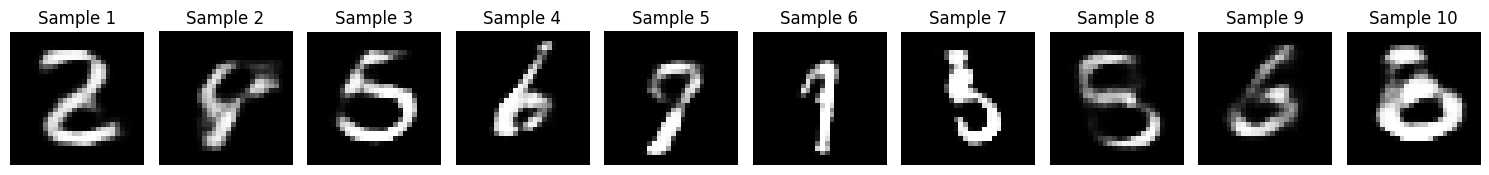

In [44]:
# Generation code provided by gpt:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Number of new images to generate
num_samples = 10

# Latent dimension (should match the `latent_size` used in your model)
latent_dim = 20

# Generate random latent vectors z from a standard normal distribution
z = torch.randn(num_samples, latent_dim)

# Pass the latent vectors through the decoder to generate images
with torch.no_grad():  # No gradients needed during inference
    generated = model.fc4(z)  # Start decoding from the latent layer
    generated = F.relu(model.fc5(generated))
    generated = F.relu(model.fc6(generated))
    generated = torch.sigmoid(model.out(generated))  # Ensure outputs are in [0, 1]

# Reshape generated images to their original dimensions (e.g., 28x28)
generated_images = generated.view(num_samples, 1, 28, 28)

# Plot the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Sample {i+1}")

plt.tight_layout()
plt.show()
